## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf

import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog
tkinter.Tk().withdraw()
path=filedialog.askdirectory(title='path for whole dataset')
#date="Oct15_Same"
date="Sep9_Same_Dataset_Balanced"
mask="Dataset1_Sep9"
csv_path=3
from glob import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

#tf_device='/gpu:0'
path_gen="../"+date+"/Generator"
path_dis="../"+date+"/Discriminator"

2024-09-10 00:08:30.730609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices('GPU')

2024-09-10 00:08:47.783335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-09-10 00:08:47.813480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-09-10 00:08:47.813500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-10 00:08:47.815711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-10 00:08:47.815745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-09-10 00:08:47.817307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2024-09-10 00:08:47.817928: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 350 #350
IMAGE_SIZE=256

#Image_number=4050

In [5]:
def load_data(path, split=0.05):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    print(len(images))
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled'

In [7]:
# Helper function to extract filenames
def get_filenames(paths):
    return [os.path.basename(path) for path in paths]

# Modified load functions
def load_train_with_filename(path, label, filename):
    image, real_image = load_train(path, label)
    return image, real_image, filename

def load_test_with_filename(path, label, filename):
    image, real_image = load_test(path, label)
    return image, real_image, filename

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

4944


In [9]:
train_x

['/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/001607.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/016265.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/007592.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/005265.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/013827.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Images/004071.png',
 '/media/saab/f7ee81f1-4052-

In [10]:
len(train_y)

4450

In [11]:
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    
    input_image = tf.image.decode_png(image1)
   
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
        #input_image,real_image=augment(input_image,real_image)
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [12]:
def load_test(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [13]:
def load_valid(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    if(input_image.shape!=([256,256,3])):
        print(input_image.shape)
        print(256-input_image.shape[0])
        print(256-input_image.shape[1])
        input_image=tf.image.pad_to_bounding_box(input_image,0,0,256,256)
    #input_image=tf.image.resize(input_image, [256, 256],
     #                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        #real_image=tf.image.resize(real_image, [256, 256],
                       #   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

 
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [14]:
len(test_y)

247

In [15]:
import random

def augment(input_image, real_image):
    seed = (1, 2)
    tf.random.set_seed(1234)

    if tf.random.uniform(()) > 0.5:
        # Random brightness
        

        # Random saturation
        input_image = tf.image.stateless_random_saturation(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_saturation(real_image, lower=0, upper=1.5, seed=seed)

        # Random contrast
        input_image = tf.image.stateless_random_contrast(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_contrast(real_image, lower=0, upper=1.5, seed=seed)

        input_image = tf.image.adjust_gamma(input_image, gamma= random.uniform(0.5, 2.0))
        real_image = tf.image.adjust_gamma(real_image, gamma= random.uniform(0.5, 2.0))

    
        input_image = tf.clip_by_value(input_image, 0, 255)
        real_image = tf.clip_by_value(real_image, 0, 255)


    return input_image, real_image

In [16]:
import random

def augment(input_image, real_image):
    # Set a seed for reproducibility
    seed = (1, 2)
    tf.random.set_seed(1234)
    
    # Apply random rotation by 90 degrees
    if tf.random.uniform(()) > 0.5:
        num_rotations = random.choice([1, 2, 3])  # Randomly choose 90, 180, or 270 degrees rotation
        input_image = tf.image.rot90(input_image, k=num_rotations)
        real_image = tf.image.rot90(real_image, k=num_rotations)
    
    return input_image, real_image


In [17]:
# Train dataset
train_filenames = get_filenames(train_x)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y, train_filenames))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_train_with_filename)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Validation dataset
valid_filenames = get_filenames(valid_x)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y, valid_filenames))
valid_dataset = valid_dataset.map(load_test_with_filename)
valid_dataset = valid_dataset.batch(1)

# Test dataset
test_filenames = get_filenames(test_x)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y, test_filenames))
test_dataset = test_dataset.map(load_test_with_filename)
test_dataset = test_dataset.batch(1)

2024-09-10 00:08:52.087163: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 00:08:52.111243: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699610000 Hz
2024-09-10 00:08:52.112387: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f83747b410 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-09-10 00:08:52.112401: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-09-10 00:08:52.202918: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f8378b58e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-1

In [18]:
inp,re=load_train(train_x[10],train_y[10])

2024-09-10 00:08:53.267347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 017243.png
tf.Tensor(-0.70980394, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-0.70980394, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 004899.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 007925.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 007793.png
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
Filename: 017900.png


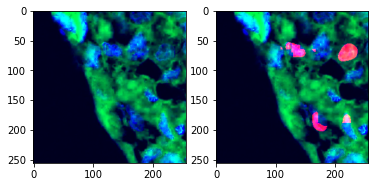

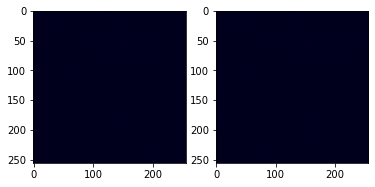

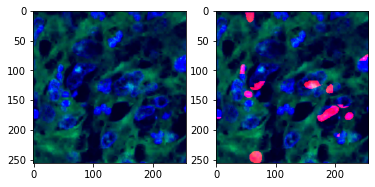

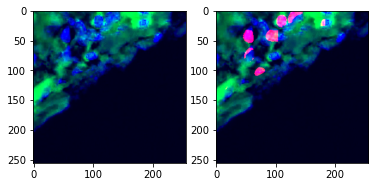

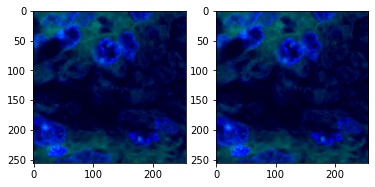

In [19]:
for x, y, filename in train_dataset.take(1):
    # print(x.shape[0])
    for i in range(5):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x[i]*0.5+0.5)
        print(tf.reduce_max(x[i]))
        print(tf.reduce_min(x[i]))
        plt.subplot(1,2,2)
        plt.imshow(y[i]*0.5+0.5)
        print(tf.reduce_max(y[i]))
        print(tf.reduce_min(y[i]))
        print("Filename:", filename[i].numpy().decode('utf-8'))

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2024-09-10 00:08:55.927848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1, 128, 128, 3)


2024-09-10 00:08:56.923151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
def Generator():
  size=4
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, size, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128,size), # (bs, 64, 64, 128)
    downsample(256, size), # (bs, 32, 32, 256)
    downsample(512, size), # (bs, 16, 16, 512)
    downsample(512, size), # (bs, 8, 8, 512)
    downsample(512, size), # (bs, 4, 4, 512)
    downsample(512, size), # (bs, 2, 2, 512)
    downsample(512, size), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, size, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, size), # (bs, 16, 16, 1024)
    upsample(256, size), # (bs, 32, 32, 512)
    upsample(128, size), # (bs, 64, 64, 256)
    upsample(64, size), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

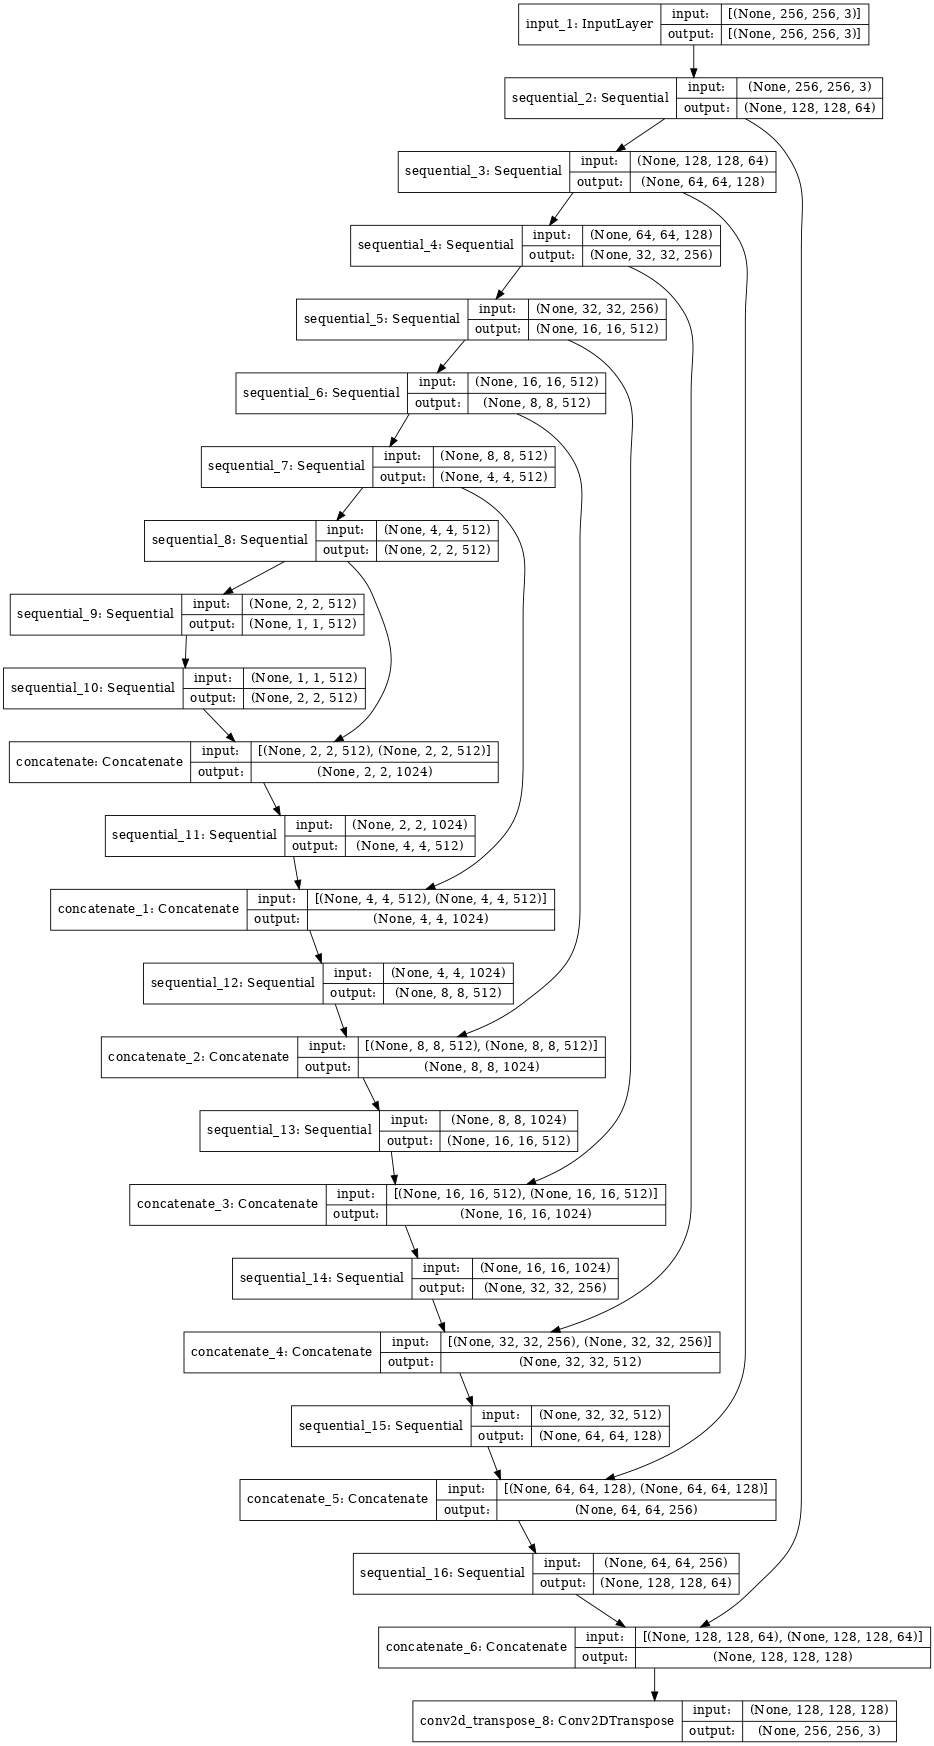

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [27]:
for i, layer in enumerate(generator.layers):
    print(f"{layer.name}, Type: {layer.__class__.__name__}, Output Shape: {layer.output_shape}, Params: {sum(p.size for p in layer.get_weights())}")

input_1, Type: InputLayer, Output Shape: [(None, 256, 256, 3)], Params: 0
sequential_2, Type: Sequential, Output Shape: (None, 128, 128, 64), Params: 3072
sequential_3, Type: Sequential, Output Shape: (None, 64, 64, 128), Params: 131584
sequential_4, Type: Sequential, Output Shape: (None, 32, 32, 256), Params: 525312
sequential_5, Type: Sequential, Output Shape: (None, 16, 16, 512), Params: 2099200
sequential_6, Type: Sequential, Output Shape: (None, 8, 8, 512), Params: 4196352
sequential_7, Type: Sequential, Output Shape: (None, 4, 4, 512), Params: 4196352
sequential_8, Type: Sequential, Output Shape: (None, 2, 2, 512), Params: 4196352
sequential_9, Type: Sequential, Output Shape: (None, 1, 1, 512), Params: 4196352
sequential_10, Type: Sequential, Output Shape: (None, 2, 2, 512), Params: 4196352
concatenate, Type: Concatenate, Output Shape: (None, 2, 2, 1024), Params: 0
sequential_11, Type: Sequential, Output Shape: (None, 4, 4, 512), Params: 8390656
concatenate_1, Type: Concatenate, 

In [28]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(generator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [29]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")


generator.summary(positions = [1, 6, 2, 23], print_fn=custom_print_fn)

In [30]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = generator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)


In [31]:
import re
import csv

# Assuming 'input.txt' contains the text with dotted lines
file_path = 'model_summary.txt'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Define a regular expression to capture the content between the dotted lines
pattern = re.compile(r"_+([\w\d\[\]\(\)]+)_+")

# Find all matches in the content
matches = re.findall(pattern, content)

# Write the matches to a CSV file
csv_file_path = 'output.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Layer'])  # Write header

    for match in matches:
        csv_writer.writerow([match])

print(f"Data has been extracted and saved to {csv_file_path}.")


Data has been extracted and saved to output.csv.


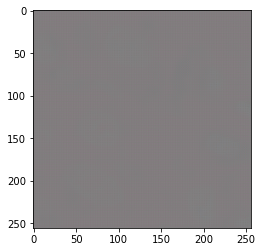

In [32]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [34]:
def extract_cd3_positive_regions(image, min_red_intensity=-0.9):
    # Assuming 'image' is in the format (height, width, channels) where channels represent RGB

    red_channel = image[:, :, 0]  # Red channel

    # Create a binary mask based on red pixel intensity
    binary_mask = tf.cast(red_channel > min_red_intensity, tf.float32)

    return binary_mask

In [35]:
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + 1e-6)  # Adding a small constant to avoid division by zero

In [36]:
def intersection_over_union(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6) 

In [37]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

In [38]:

def fuzzy_jaccard_loss(y_true, y_pred, tolerance=0.1):
    """
    Calculate the Fuzzy Jaccard Loss for two normalized grayscale images.
    This function is designed to be used as a loss function in TensorFlow models.

    Parameters:
    y_true : Tensor
        Ground truth normalized grayscale image.
    y_pred : Tensor
        Predicted normalized grayscale image.
    tolerance : float
        Maximum difference in intensity values to be considered similar.

    Returns:
    Tensor
        Fuzzy Jaccard Loss (1 - Fuzzy Jaccard Index).
    """
    # Ensure the tensors are of the same shape
    tf.debugging.assert_equal(tf.shape(y_true), tf.shape(y_pred), 
                              message="Inputs must have the same shape")

    # Calculate the similarity matrix
    similarity_matrix = tf.exp(-tf.abs(y_true - y_pred) / tolerance)

    # Calculate the intersection and union
    intersection = tf.reduce_sum(similarity_matrix)
    union = tf.cast(tf.size(y_true), tf.float32)  # Total number of pixels

    # Calculate the Fuzzy Jaccard Index
    fuzzy_jaccard = intersection / union

    # Return the loss (1 - Fuzzy Jaccard Index)
    return 1.0 - fuzzy_jaccard

In [39]:
LAMBDA = 100

In [67]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  gen_mask_1 = extract_cd3_positive_regions(gen_output, min_red_intensity=-0.9)
  target_mask_1 = extract_cd3_positive_regions(target,min_red_intensity=-0.9)
  dice_loss_1 = 1 - dice_coefficient(target_mask_1, gen_mask_1)

  # Dice coefficient loss
  #iou_loss = 1 - intersection_over_union(target_mask, gen_mask)
  #dice_loss = 1 - dice_coefficient(target_mask, gen_mask)

  lambda_dice1 = 1000

  iou_loss = lambda_dice1*dice_loss_1

  lambda_focal = 200
  #cd3_loss = focal_loss(target_mask, gen_mask)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  jacard_loss = fuzzy_jaccard_loss(target, gen_output)
  #LAMBDA=dynamic_lambda(target,gen_output)

#  red_mae_loss = tf.reduce_mean(tf.abs((target - gen_output) * target_mask))

  total_gen_loss = gan_loss + LAMBDA*l1_loss + lambda_dice1*dice_loss_1 

  return total_gen_loss, gan_loss, l1_loss, iou_loss

In [68]:
# For the test dataset
for x, y, filename in test_dataset.take(20):
    a = (extract_cd3_positive_regions(image=y[0], min_red_intensity=-0.9))
    b = (extract_cd3_positive_regions(image=x[0], min_red_intensity=-0.9))
    print(250*(1-dice_coefficient(a,b)))
    print("Filename:", filename[0].numpy().decode('utf-8'))

tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 010402.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 013084.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 008205.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 007892.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 001030.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 003762.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 009570.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 014495.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 016271.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 008051.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 007726.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 009023.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 007982.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 000170.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 011582.png
tf.Tensor(250.0, shape=(), dtype=float32)
Filename: 015

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [69]:
def Discriminator():
  size=4
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, size, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, size)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, size)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, size, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

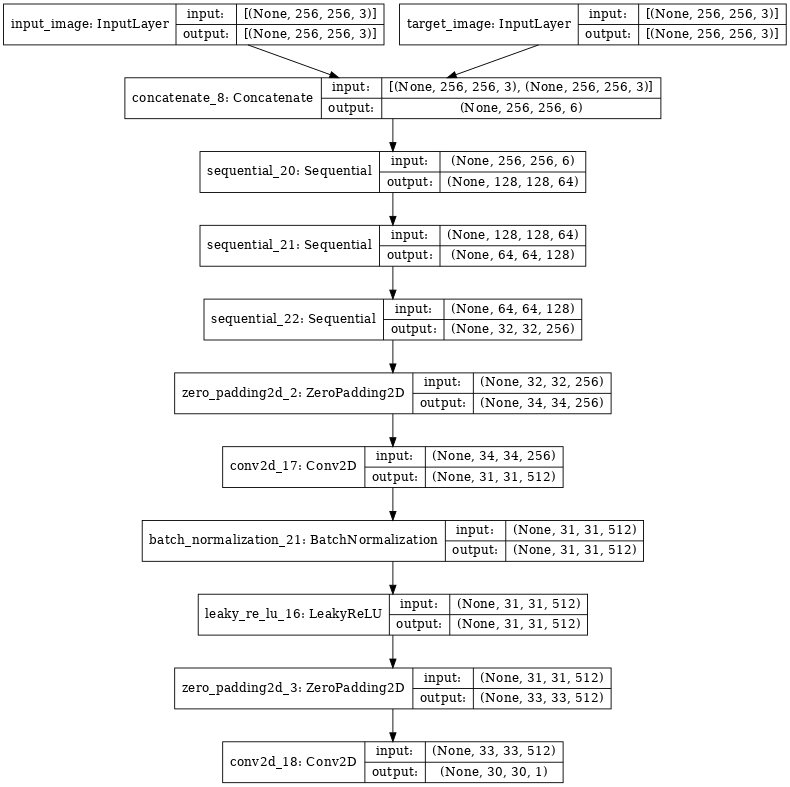

In [70]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [71]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(discriminator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [72]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = discriminator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)

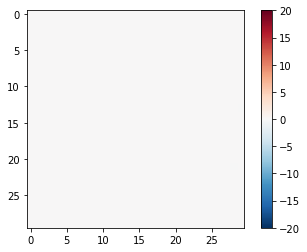

In [73]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [74]:
#1-bce-dice

def loss_object_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    l=loss_object1(y_true,y_pred)
    return tf.abs(-l+(numerator / denominator))

In [75]:
def dynamic_lambda(i1,i2):
  
    a=tf.equal(i1,i2)
    b=tf.cast(a,tf.float32)
    
    L=LAMBDA/(0.1+tf.reduce_mean(b))
    tf.print(L, output_stream=sys.stderr)
    return L

In [76]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    #print(total_disc_loss)
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [77]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [78]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_prefix, max_to_keep=5)

In [79]:
#checkpoint.save(file_prefix = checkpoint_prefix)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [80]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
 
    plt.figure(figsize=(15,15))
    a=extract_cd3_positive_regions(tar[0])
    b=extract_cd3_positive_regions(prediction[0])
    display_list = [test_input[0], tar[0],a, prediction[0],b]
    title = ['Input Image', 'Ground Truth','GT Segmentation', 'Predicted Image','Predict Segmentation']
    print(dice_coefficient(a,b))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    return display_list,title

tf.Tensor(0.0, shape=(), dtype=float32)


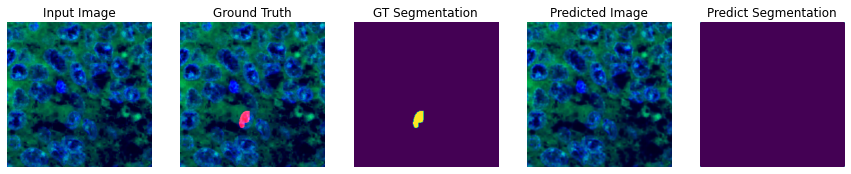

tf.Tensor(0.0, shape=(), dtype=float32)


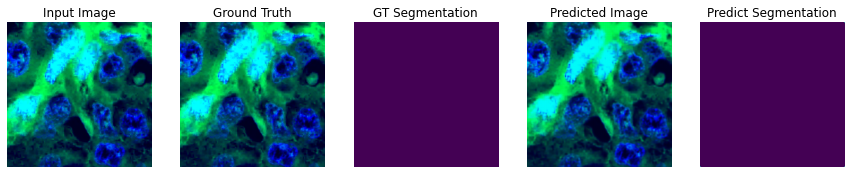

tf.Tensor(0.0, shape=(), dtype=float32)


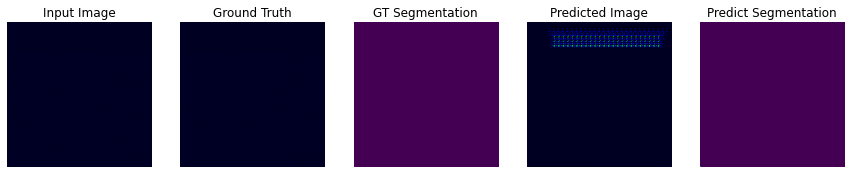

tf.Tensor(0.0, shape=(), dtype=float32)


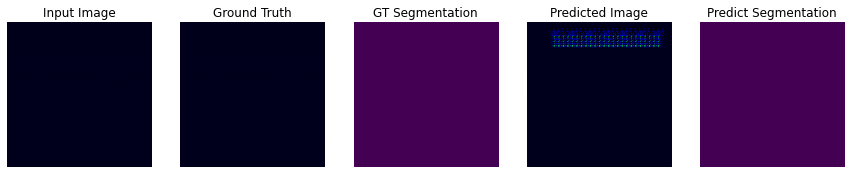

tf.Tensor(0.0, shape=(), dtype=float32)


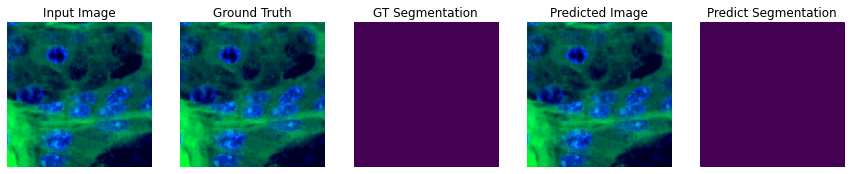

In [81]:
for example_input, example_target, example_filename in train_dataset.take(5):
    generate_images(generator, example_input, example_target)

In [82]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
______________________________________________________________________________________________

In [83]:
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 128, 128, 64) 6144        concatenate_8[0][0]        

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [84]:
EPOCHS = 50

In [85]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [86]:
disc_loss_1=[]
gen_total_loss_1=[]
gen_l1_loss_1=[]
gen_gan_loss_1=[]
psnr=[]
ssim=[]

In [87]:
@tf.function
def train_step(input_image, target, filename, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    ps=tf.reduce_mean(tf.image.psnr(gen_output,target, max_val=1.0))
    #tf.print(ps)
    #psnr.append(ps)
    ss=tf.reduce_mean(tf.image.ssim(gen_output,target, 1.0))
    #ssim.append(ss)
    #tf.print(ss)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss,iou_val = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    tf.summary.scalar('ssim', ss, step=epoch)
    tf.summary.scalar('psnr', ps, step=epoch)
    tf.summary.scalar('1-iou',iou_val,step=epoch)
    #print("gen_l1_loss")
    #tf.print(gen_l1_loss, output_stream=sys.stderr)
    #print("gen_gan_loss")
    #tf.print(ss, output_stream=sys.stderr)
    #tf.print(gen_gan_loss, output_stream=sys.stderr)
    #print("disc_loss")
    #tf.print(disc_loss, output_stream=sys.stderr)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,disc_loss,ps,ss

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [88]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)
        
        # Update test dataset iteration
        for example_input, example_target, example_filename in test_ds.take(15):
            imgs, titles = generate_images(generator, example_input, example_target)
            # If you want to use filenames, you can do something like:
            # print("Example filename:", example_filename.numpy().decode('utf-8'))
        
        print("Epoch: ", epoch)
        
        # Train
        for n, (input_image, target, filename) in enumerate(train_ds):
            print('.', end='')
            
            # Update train_step call
            # If train_step doesn't use filename, you can pass it as None or modify train_step
            train_step(input_image, target, filename, epoch)
        
        # saving (checkpoint) the model every epoch
        manager.save()
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

In [89]:
checkpoint_dir

'./training_checkpoints/Sep9_Same_Dataset_Balanced/Dataset1_Sep9'

In [90]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))
#generator.load_weights(path_gen)
#discriminator.load_weights(path_dis)

tf.Tensor(0.0, shape=(), dtype=float32)


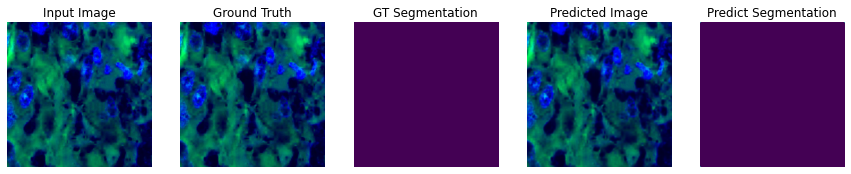

tf.Tensor(0.0, shape=(), dtype=float32)


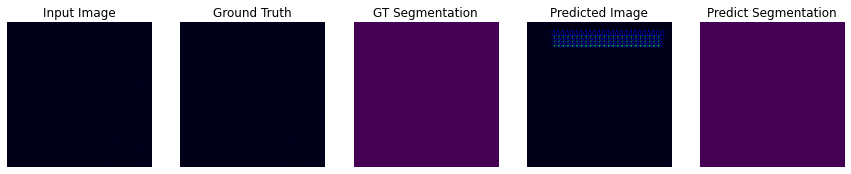

tf.Tensor(0.0, shape=(), dtype=float32)


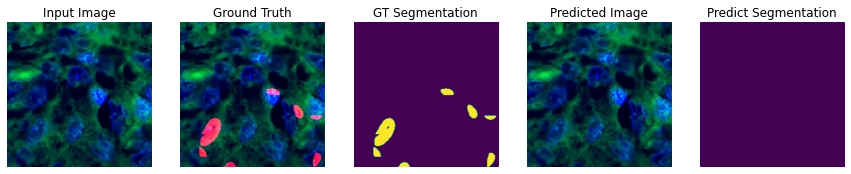

tf.Tensor(0.0, shape=(), dtype=float32)


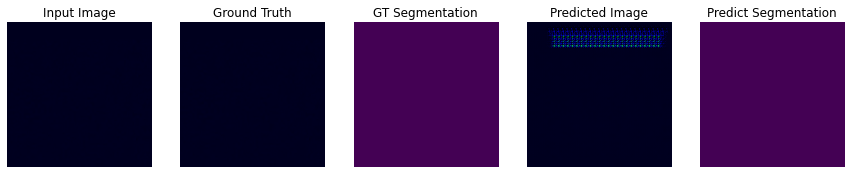

tf.Tensor(0.0, shape=(), dtype=float32)


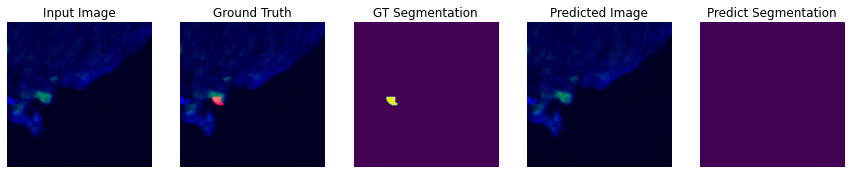

tf.Tensor(0.0, shape=(), dtype=float32)


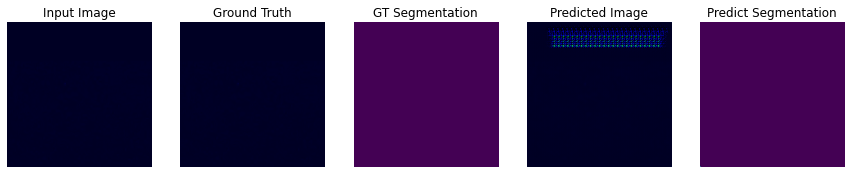

tf.Tensor(0.0, shape=(), dtype=float32)


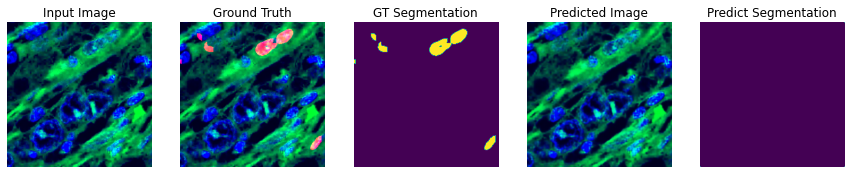

tf.Tensor(0.0, shape=(), dtype=float32)


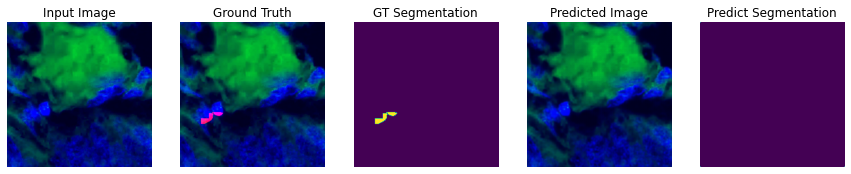

tf.Tensor(0.0, shape=(), dtype=float32)


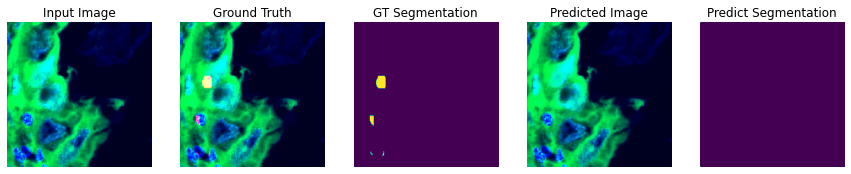

tf.Tensor(0.0, shape=(), dtype=float32)


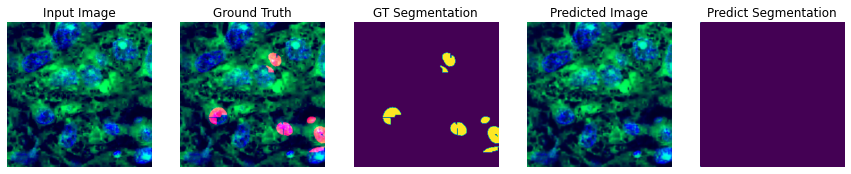

In [91]:
for example_input, example_target, filename in train_dataset.take(10):
            generate_images(generator, example_input, example_target)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [92]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1097704), started 2:31:48 ago. (Use '!kill 1097704' to kill it.)

Now run the training loop:

tf.Tensor(0.0, shape=(), dtype=float32)


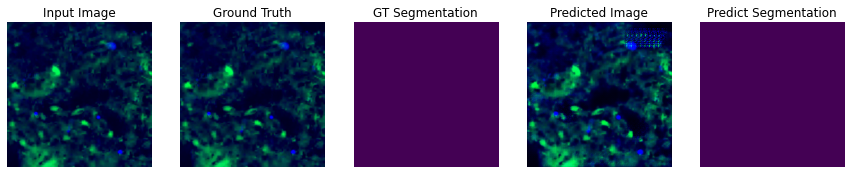

tf.Tensor(0.0, shape=(), dtype=float32)


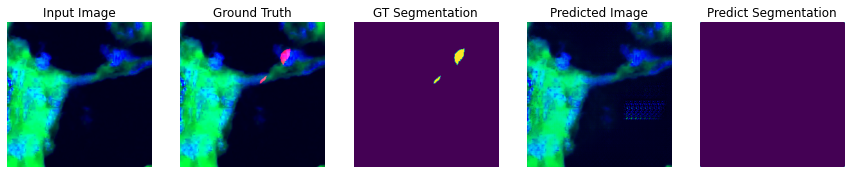

tf.Tensor(0.0, shape=(), dtype=float32)


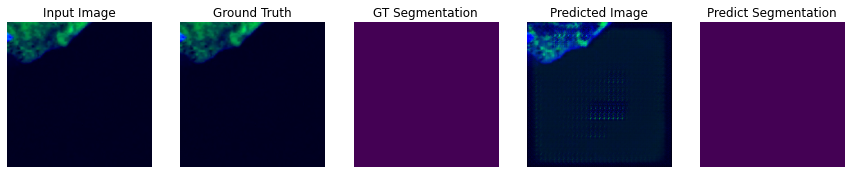

tf.Tensor(0.0, shape=(), dtype=float32)


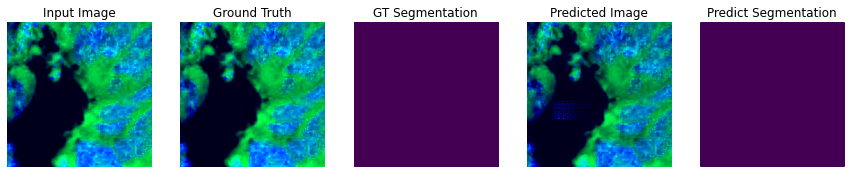

tf.Tensor(0.0, shape=(), dtype=float32)


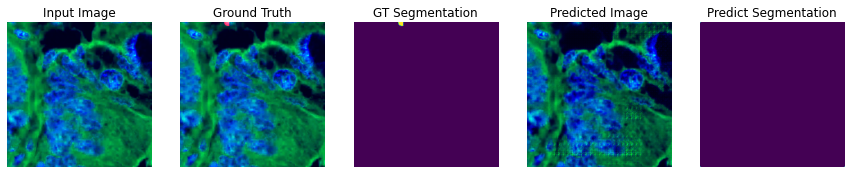

tf.Tensor(0.0, shape=(), dtype=float32)


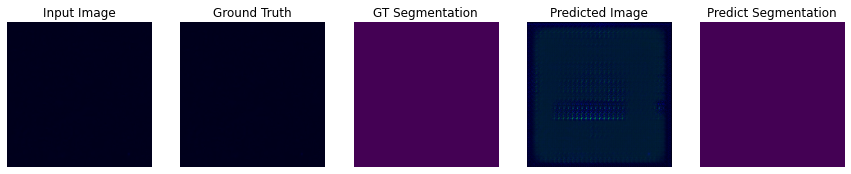

tf.Tensor(0.0, shape=(), dtype=float32)


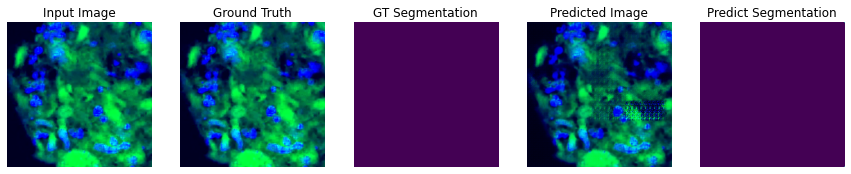

tf.Tensor(0.0, shape=(), dtype=float32)


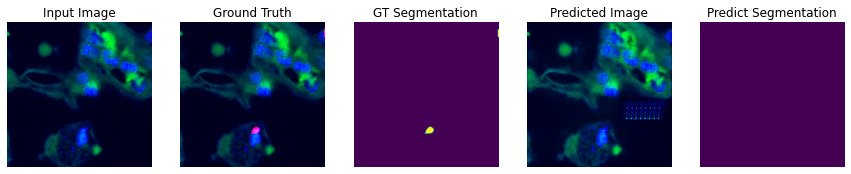

tf.Tensor(0.0, shape=(), dtype=float32)


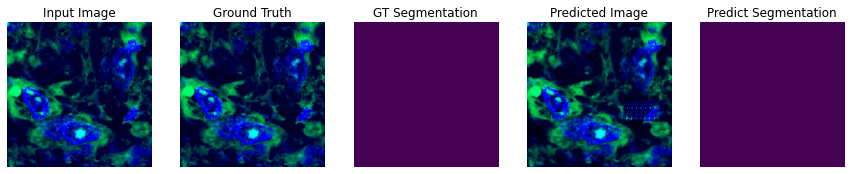

tf.Tensor(0.0, shape=(), dtype=float32)


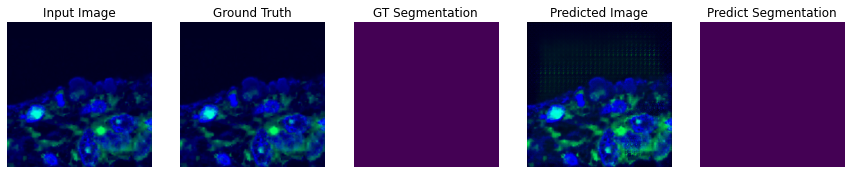

tf.Tensor(0.0, shape=(), dtype=float32)


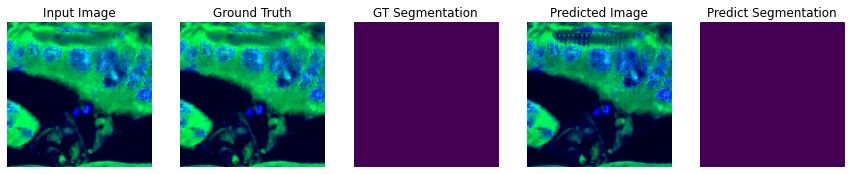

tf.Tensor(0.0, shape=(), dtype=float32)


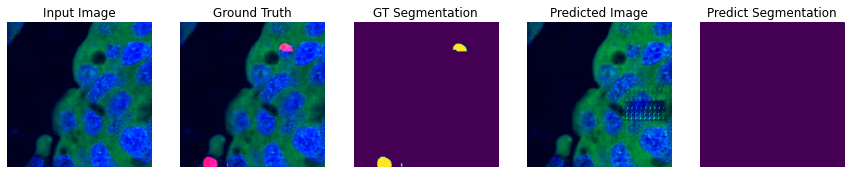

tf.Tensor(0.0, shape=(), dtype=float32)


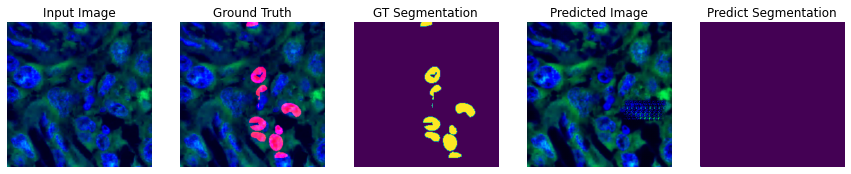

tf.Tensor(0.0, shape=(), dtype=float32)


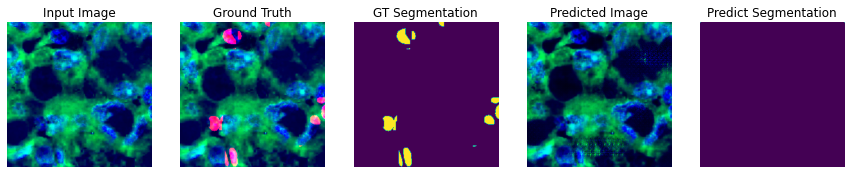

tf.Tensor(0.0, shape=(), dtype=float32)


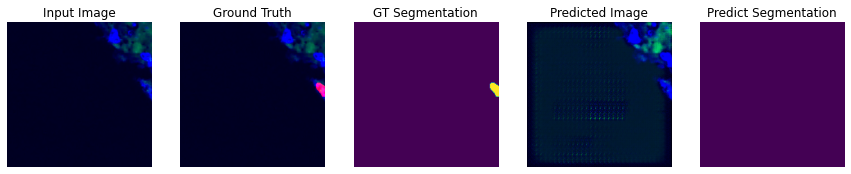

Epoch:  49
.............Time taken for epoch 50 is 47.67 sec



In [93]:
fit(train_dataset, int(EPOCHS), valid_dataset)

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## CSV files to get shuffled patch indices (Running once is sufficient)

In [94]:
lst_sort=[]
images = sorted(glob(os.path.join(path, "Images/*")))
for x,y in zip(train_x,images):
    lst_sort.append([x.split("/")[-1],y.split("/")[-1]])

import pandas as pd
df_lst=pd.DataFrame(lst_sort)

# Get shuffled patch indices
df_lst.to_csv("/home/saab/Desktop/file_paths_Sep9_2024.csv")

In [95]:
lst_sort2=[]
for x in(test_x):
    lst_sort2.append([x.split("/")[-1]])
for x in(valid_x):
    lst_sort2.append([x.split("/")[-1]])
df_lst=pd.DataFrame(lst_sort2)
df_lst.to_csv("/home/saab/Desktop/file_paths_test_Sep9_2024.csv")

# Asking paths

In [96]:
p_train = filedialog.askdirectory(title='path for train_results')
p_test = filedialog.askdirectory(title='path for test_results')

In [97]:
p_train

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68_Same/1-image extraction/blue_nuclei/After/Data_Oversampled/Train'

# Training dataset inference

In [99]:
def save_images(dataset, base_path):
    i=0
    for x, y, filenames in dataset:
        for a, b, fname in zip(x, y, filenames):
            v = generator(np.expand_dims(a, axis=0))
            img1 = v[0] * 0.5 + 0.5
            img2 = b * 0.5 + 0.5
            img3 = a * 0.5 + 0.5
            
            base_name = os.path.splitext(fname.numpy().decode('utf-8'))[0]
            
            plt.imsave(os.path.join(base_path, "pred", f"{base_name}_pred.png"), img1.numpy())
            plt.imsave(os.path.join(base_path, "gt", f"{base_name}_gt.png"), img2.numpy())
            plt.imsave(os.path.join(base_path, "img", f"{base_name}_input.png"), img3.numpy())
            print(base_name, end=" ")

# Save train images
save_images(train_dataset, p_train)


013274 017509 007896 013379 007991 005405 018625 015323 009584 005607 010387 015752 016008 010557 000323 004071 007797 015932 015588 014739 017565 011647 000705 018867 002170 018943 004266 014661 017966 009836 009407 001489 014090 018164 017794 007366 018505 005061 003912 014150 015444 002154 015789 013780 004351 003993 005772 011180 015247 002871 000036 002847 006891 009063 008413 017522 018741 011094 010441 007803 014769 005457 004206 016254 017118 014716 012114 002494 005769 014071 010468 015944 001784 006789 012810 013384 015511 017531 003191 001630 015281 004050 014670 016493 015620 015090 006722 007367 006356 014114 009255 012172 015266 006633 007364 012774 004481 001027 009414 016132 002161 004744 005864 014147 000973 006256 000610 011217 008561 006883 016079 008351 017803 005063 010421 011959 016664 001679 007954 007142 013006 006341 013686 001799 009115 017993 007420 008030 001865 008076 016715 014184 000263 001584 004080 002492 009903 014386 002909 012446 003852 007282 005994

# Testing dataset inference

In [100]:

def save_images(dataset1, base_path):
    for x, y, filenames in dataset1:
        for a, b, fname in zip(x, y, filenames):
            v = generator(np.expand_dims(a, axis=0))
            img1 = v[0] * 0.5 + 0.5
            img2 = b * 0.5 + 0.5
            img3 = a * 0.5 + 0.5
            
            base_name = os.path.splitext(fname.numpy().decode('utf-8'))[0]
            
            plt.imsave(os.path.join(base_path, "pred", f"{base_name}_pred.png"), img1.numpy())
            plt.imsave(os.path.join(base_path, "gt", f"{base_name}_gt.png"), img2.numpy())
            plt.imsave(os.path.join(base_path, "img", f"{base_name}_input.png"), img3.numpy())
            print(base_name, end=" ")
            

# Save test and validation images
save_images(test_dataset, p_test)
save_images(valid_dataset, p_test)

010402 013084 008205 007892 001030 003762 009570 014495 016271 008051 007726 009023 007982 000170 011582 015316 000899 012907 003580 000993 011483 012283 015500 018371 010704 009595 005543 005055 010664 018733 010964 000413 017303 012043 002017 005885 005390 009808 006258 018855 017613 005394 012795 010687 014487 017023 004810 001683 008192 015702 009198 012529 005246 007577 014849 010578 005295 013129 014474 001576 018906 018933 015301 003540 015496 001549 011982 012189 004397 008436 001716 007203 001083 003878 014942 015346 013067 015585 017627 003755 000309 013365 004644 001930 005192 012623 013955 008035 001517 005136 013612 011405 018287 001451 013450 005446 011846 016677 004911 017470 004906 001654 018966 005012 004951 008233 003671 007114 009718 007362 005921 018502 001155 012906 011465 004640 010567 012111 010080 001819 014385 014315 012525 003666 005830 012751 012818 010064 015647 012150 017468 000189 012096 004265 006631 007645 018866 001903 006939 005247 002079 008913 002311

In [101]:
plt.imshow(img1.numpy())

NameError: name 'img1' is not defined

In [ ]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
len(st)

204

In [ ]:
st

['A006',
 'A008',
 'A012',
 'A015',
 'A016',
 'A017',
 'A021',
 'A025',
 'A027',
 'A028',
 'A033',
 'A037',
 'A062',
 'A063',
 'A066',
 'A068',
 'A071',
 'A072',
 'A073',
 'A074',
 'A100',
 'A101',
 'A102',
 'A103',
 'A104',
 'A109',
 'A110',
 'A111',
 'A112',
 'A114',
 'A117',
 'A120',
 'A122',
 'A124',
 'A126',
 'A130',
 'A131',
 'A134',
 'A136',
 'A138',
 'A139',
 'A143',
 'A144',
 'A146',
 'A147',
 'A148',
 'A149',
 'A150',
 'A152',
 'A153',
 'A155',
 'A156',
 'A157',
 'A158',
 'A159',
 'A162',
 'A163',
 'A165',
 'A167',
 'A168',
 'A169',
 'A177',
 'A182',
 'A183',
 'A184',
 'A185',
 'A186',
 'A187',
 'A188',
 'A190',
 'A191',
 'A192',
 'A193',
 'A194',
 'A195',
 'A196',
 'A197',
 'A198',
 'A199',
 'A200',
 'A201',
 'A202',
 'A204',
 'A205',
 'A206',
 'A207',
 'A208',
 'A209',
 'A210',
 'A211',
 'A212',
 'A213',
 'A214',
 'A215',
 'A216',
 'A217',
 'A218',
 'A219',
 'A220',
 'A221',
 'A222',
 'A228',
 'A229',
 'A230',
 'A232',
 'A233',
 'A234',
 'A239',
 'A240',
 'A241',
 'A243',
 

In [ ]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")


In [ ]:
path_predict_onco_sg

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled'

In [ ]:

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A006/A006, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A008/A008, paillary, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A012/A012, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A015/A015, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A016/A016, solid, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/

In [71]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '009.png',
 '010.png',
 '011.png',
 '012.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '017.png',
 '018.png',
 '019.png',
 '020.png',
 '021.png',
 '022.png',
 '023.png',
 '024.png',
 '025.png',
 '026.png',
 '027.png',
 '028.png',
 '029.png',
 '030.png',
 '031.png',
 '032.png',
 '033.png',
 '034.png',
 '035.png',
 '036.png',
 '037.png',
 '038.png',
 '039.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png']

In [72]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

In [76]:


for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_valid(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

420
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16


(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 240, 3)
184
16
441
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105

# Extra code

In [ ]:
#!pip install pandas
import pandas as pd



In [ ]:
images = sorted(glob(os.path.join(path, "images/*")))
masks = sorted(glob(os.path.join(path, "masks/*")))


In [ ]:
green = np.zeros([256,256,3],dtype=np.float32)
green[:]=(0,225,0)
green=green/127.5-1

In [ ]:
ind_ssim=[]
numbers=[]
for i in range(len(images)):
    print(i)
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    ss=tf.reduce_mean(tf.image.ssim(v,np.expand_dims(b,axis=0), 1.0))
    #gre=tf.reduce_mean(tf.math.sqrt(tf.abs(tf.math.square(green)-tf.math.square(v[0]))))
    img=v[0]*0.5+0.5
    plt.imshow(img.numpy())
    #tf.print(gre)
    
    ind_ssim.append((ss.numpy(),i))

    #img=np.asarray(v[0]*0.5+0.5,np.uint8)

In [ ]:
ind_ssim.sort()

In [ ]:
max(ind_ssim)

In [ ]:
ssim3=[]
for x in ind_ssim:
    ssim3.append(x[1])

In [ ]:

df_ssim_3=pd.DataFrame({"old_numbers":ssim3})

In [ ]:
df_ssim_3

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:

df_ssim_3=pd.read_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")
path_to_store=os.getcwd()+"/ans_cd3_new/"+date+"/"+mask+"/"
p1=os.path.join(path_to_store,"sorted")
p2=os.path.join(path_to_store,"unsorted")
p3=os.path.join(path_to_store,"sorted_gt")
p4=os.path.join(path_to_store,"unsorted_gt")
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
os.makedirs(p4,exist_ok=True)

In [ ]:
ssim3=df_ssim_3["old_numbers"].tolist()

In [ ]:
ssim3

In [ ]:
x=0
for i in (ssim3):
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    img2=b*0.5+0.5
    #plt.figure()
    #plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    
    plt.imsave(p1+"/"+f"{x:06d}"+".png",img.numpy())
    plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    plt.imsave(p3+"/"+f"{x:06d}"+".png",img2.numpy())
    plt.imsave(p4+"/"+f"{i:06d}"+".png",img2.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
b_test=glob(os.getcwd()+"/gt/*.png")
p099=os.getcwd()+"/new_test_dataset_results"+date
os.makedirs(p099,exist_ok=True)
x=0
for i in (b_test):
    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    #img2=b*0.5+0.5
    plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    plt.imsave(p099+"/"+f"{x:06d}"+".png",img.numpy())
    #plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:
os.getcwd()+"/old_nos_new_test"+date+".csv"

In [ ]:
new_test_path="/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles"
test_imgs_cptac=sorted(glob(new_test_path+"/*.png"))
len(test_imgs_cptac)

In [ ]:
x=0
test_predict=sorted(glob("/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/*"))
test_predict

In [ ]:
tpi=os.getcwd()+"/predict_hcc1_2"
os.makedirs(tpi,exist_ok=True)
for i in test_predict:

    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5

    plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())

    print(x,end=" ")
    x=x+1

In [ ]:
for tp in test_predict:
    x=0
    tpi=tp+"/predict"
    os.makedirs(tpi,exist_ok=True)
    test_imgs_cptac=sorted(glob(tp+"/small_tiles/*"))
    for i in (test_imgs_cptac):
        a=load(i,condtn=False)
        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5
    
        plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())
    
        print(x,end=" ")
        x=x+1
    print(" ")

In [ ]:
test_y

In [ ]:
p1=filedialog.askdirectory(title='path for unsorted_gt')
print(len(glob(p1+"/*.png")))
p2=filedialog.askdirectory(title='path for unsorted_pred')
print(len(glob(p2+"/*.png")))

In [ ]:
for x in test_y:
    os.remove(p1+"/"+x.split("/")[-1])
    os.remove(p2+"/"+x.split("/")[-1])

In [ ]:
print(len(glob(p1+"/*.png")))
print(len(glob(p2+"/*.png")))

In [57]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Preprocessed_Data/Serial_Slide/15thOct/Dataset1_Oversampled/Dataset'